# Modules

In [ ]:
from __future__ import print_function

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
import copy
import time

%matplotlib inline

Use GPU if available



In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load data
Resize and load the image

In [ ]:
# desired size of the output image
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize,imsize)), # scale imported image    
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(path):
    image = Image.open(path)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

Reconvert a copy of it to PIL format for display.



In [ ]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def image_unloader(tensor):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    return image

def imshow(tensor, title=None):
    image = image_unloader(tensor)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

def imsave(tensor, path, name):
    output_img = image_unloader(tensor)
    output_img.save(path+name,'JPEG')

# Loss Functions
Content Loss

In [ ]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

Style Loss

In [ ]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [ ]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

# Model

Import pre-trained VGG19


In [ ]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

Normalization

VGG19 are trained on images with each channel normalized by ``mean=[0.485, 0.456, 0.406]`` and ``std=[0.229, 0.224, 0.225]``.
Use them to normalize the image before inputting it to the network.




In [ ]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

Create a new ``Sequential`` module that with content loss and style loss modules correctly inserted.




In [ ]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(vgg, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    vgg = copy.deepcopy(vgg)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle losses
    content_losses = []
    style_losses = []

    # assuming that vgg is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in vgg.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

# Gradient Descent
Use L-BFGS algorithm to run our gradient descent




In [ ]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

# Training
The main training loop

In [ ]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            #if run[0] % 50 == 0:
                #print("run {}:".format(run))
                #print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    #style_score.item(), content_score.item()))
                #print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

# Run algorithm




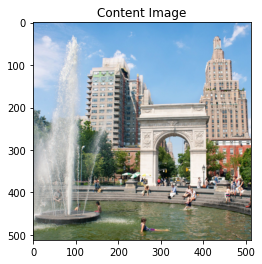

In [ ]:
style_path ="/content/drive/MyDrive/ML_Project/Style/"
style = ["Edvard Munch - The Scream",
         "Katsushika Hokusai - The Great Wave off Kanagawa",
         "Vincent Van Gogh - The Starry Night",
         "Claude Monet - Water-Lilies (1916)",
         "Leonardo Da Vinci - Portrait of Lisa Gherardini",
         "Mosaic"]
         # "Leonid Afremov - Rain Princess",
content_img = image_loader("/content/drive/MyDrive/ML_Project/Test/washington-square-park.jpeg")

plt.figure()
imshow(content_img, title='Content Image')

input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

In [ ]:
runtime = []
style_img_unloaded = []
output_img_unloaded = []

for i in range(len(style)):
  start_time = time.time()
  style_img = image_loader("/content/drive/MyDrive/ML_Project/Style/"+style[i]+'.jpg')
  assert style_img.size() == content_img.size(), \
      "we need to import style and content images of the same size"
  output = run_style_transfer(vgg, cnn_normalization_mean, cnn_normalization_std,
                              content_img, style_img, input_img, num_steps=800)
  end_time = time.time()
  runtime.append(end_time-start_time)
  style_img_unloaded.append(image_unloader(style_img))
  output_img_unloaded.append(image_unloader(output))

# sphinx_gallery_thumbnail_number = 4
# plt.ioff()
# plt.show()

Building the style transfer model..
Optimizing..


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..
Building the style transfer model..
Optimizing..


In [ ]:
print(np.array(runtime).mean())

65.0347610314687


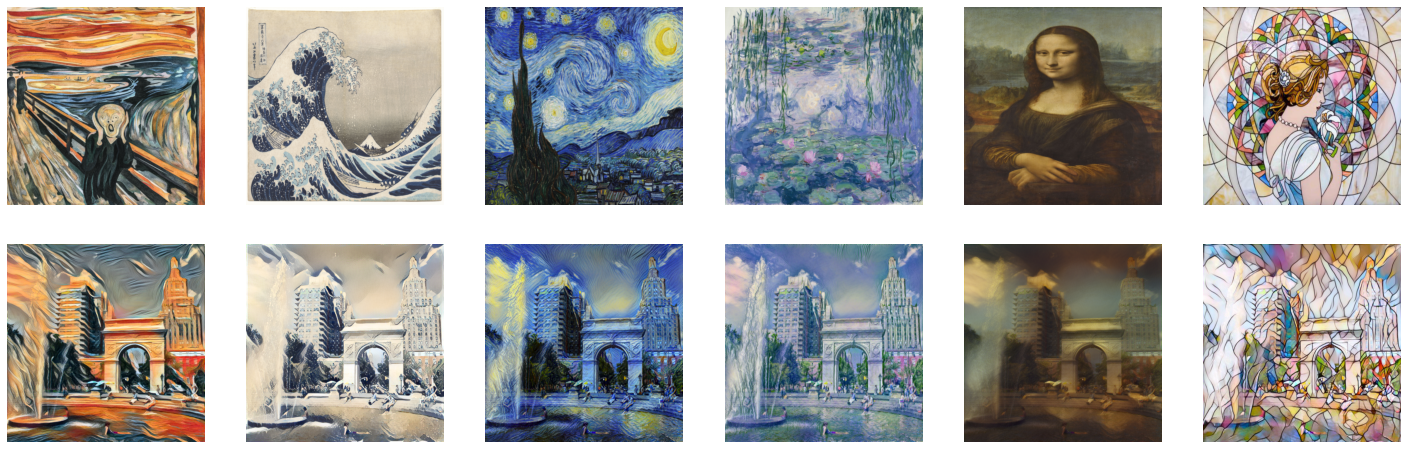

In [ ]:
plt.figure(figsize=(25,8))
total = style_img_unloaded + output_img_unloaded
for i in range(1, len(total)+1):
    plt.subplot(2,len(style),i)
    plt.imshow(total[i-1])
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')

from google.colab import files
#plt.savefig(f'/content/drive/MyDrive/ML_Project/Result/S1.png')
#files.download('/content/drive/MyDrive/ML_Project/Result/S1.png')
plt.show()